In [7]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

In [8]:
from core.cluster_validation import generate_neigbhourhood_groups, colored_crosstab
from core.utils import used_keys

In [9]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

In [10]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [11]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [12]:
spatial_lag = 3


X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
X_train = X_train[X_train.index >= 0]
X_train = X_train.clip(-10, 10)

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')
# X_train = X_train.join(lag[[c for c in lag.columns if '_median' not in c]], how='inner')

X_train = X_train.join(lag, how='inner')

X_train.shape

(286282, 236)

In [14]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [15]:
newgraph = graph.subgraph(X_train.index.values)

In [17]:
newgraph.component_labels.value_counts()

component labels
713    58362
384    24363
691    16572
66     15002
654    12865
       ...  
853        1
851        1
30         1
29         1
28         1
Name: count, Length: 884, dtype: int64

In [19]:
main_comp = 713
X_train = X_train.loc[newgraph.component_labels[newgraph.component_labels == main_comp].index]

In [20]:
# spatial_lag = 1
# X_train = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [21]:
vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [22]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [25]:
tessellation = tessellation[tessellation.index.isin(X_train.index)]

In [28]:
tess_groups = generate_neigbhourhood_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [29]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

In [30]:
# for n_neighbors in [15, 25, 50, 100]:
#     show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.0)

In [31]:
data = X_train.values

In [32]:
n_neighbors = 25
negative_sample_rate = 25
n_epochs = 500

noise_level = 0.25
learning_rate = 1

neighbor_scale = 1.0
symmetrize_graph = True
node_embedding_dim = 2

In [33]:
from evoc.knn_graph import knn_graph
from evoc.graph_construction import neighbor_graph_matrix

/home/krasen/evoc/evoc/float_nndescent.py:287: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  points = point_indices[i]


In [34]:
%%time
nn_inds, nn_dists = knn_graph(data, n_neighbors=n_neighbors)


CPU times: user 12.2 s, sys: 72.5 ms, total: 12.3 s
Wall time: 1.69 s


In [35]:
# %%time
# from fast_hdbscan.numba_kdtree import kdtree_to_numba
# from fast_hdbscan.numba_kdtree import parallel_tree_query

# graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

# from sklearn.neighbors import KDTree

# sklearn_tree = KDTree(data)
# numba_tree = kdtree_to_numba(sklearn_tree)
# result = parallel_tree_query(numba_tree, np.ascontiguousarray(data), k=n_neighbors)

# nn_dists, nn_inds = result

In [36]:
# app_nn_inds, app_nn_dists = knn_graph(data, n_neighbors=n_neighbors)

In [37]:
%%time

graph = neighbor_graph_matrix(
    neighbor_scale * n_neighbors, nn_inds, nn_dists, symmetrize_graph
)

CPU times: user 328 ms, sys: 7.91 ms, total: 336 ms
Wall time: 117 ms


In [38]:
from evoc.label_propagation import label_propagation_init

In [39]:
%%time
init_embedding = label_propagation_init(
            graph,
            n_components=node_embedding_dim,
            approx_n_parts=np.clip(int(np.sqrt(data.shape[0])), 100, 1024),
            random_scale=0.1,
            scaling=0.5,
            noise_level=noise_level,
        )

CPU times: user 1.96 s, sys: 7.78 ms, total: 1.97 s
Wall time: 138 ms


In [40]:
from evoc.node_embedding import node_embedding

In [41]:
graph = graph.tocoo()

In [42]:
%%time
embedding = node_embedding(
        graph,
        n_components=node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=init_embedding,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        verbose=True,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 54.3 s, sys: 123 ms, total: 54.4 s
Wall time: 3.39 s


In [43]:
def plot_datashade_umap(embedding, labels=None, n_neighbors=0.0, min_dist=0.0):
    class MockEmbedding(object):
        pass
    
    enb = MockEmbedding()
    enb.embedding = embedding
    enb.n_neighbors = n_neighbors
    enb.min_dist = 0.0

    if labels is None:
        return umap.plot.points(enb)
    
    return umap.plot.points(enb, labels=labels)

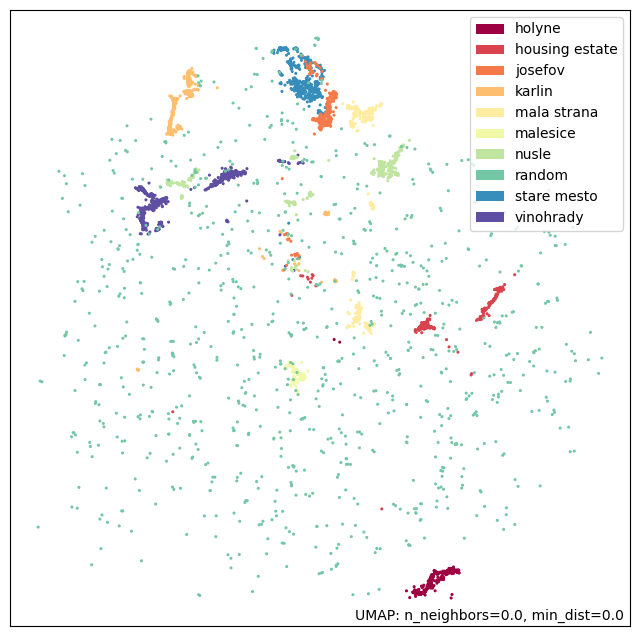

In [44]:
if node_embedding_dim == 2:
    plot_datashade_umap(embedding[tess_groups_ilocs], tess_groups.values)

In [45]:
davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

np.float64(2.420434964881649)

In [46]:
# x, y = tessellation.loc[tess_groups.index].representative_point().x.values, tessellation.loc[tess_groups.index].representative_point().y.values

In [47]:
rps = tessellation[tessellation.index.isin(X_train.index)].representative_point()
x, y = rps.x.values, rps.y.values

In [48]:
spatial_init = np.vstack((x,y)).T
spatial_init = StandardScaler().fit_transform(spatial_init)
spatial_init = np.ascontiguousarray(spatial_init, dtype=np.float32)

<Axes: >

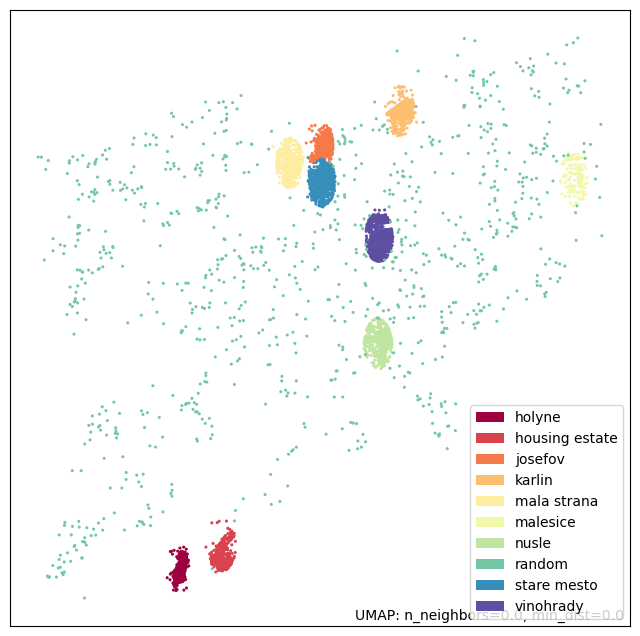

In [49]:
plot_datashade_umap(spatial_init[tess_groups_ilocs], tess_groups.values)

In [50]:
# negative_sample_rate = 50
# noise_level = .01
# n_epochs = 10000

In [51]:
new_spatial_init = spatial_init
new_node_embedding_dim = node_embedding_dim

In [52]:
# new_node_embedding_dim = 5
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init,
#                                                    np.random.randn(spatial_init.shape[0], new_node_embedding_dim - 2))), 
#                                         dtype=np.float32)
# new_spatial_init

In [53]:
# new_node_embedding_dim = spatial_init.shape[1] + init_embedding.shape[1]
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init, init_embedding)), 
#                                         dtype=np.float32)
# new_spatial_init

In [54]:
%%time
spatial_embedding = node_embedding(
        graph,
        n_components=new_node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=new_spatial_init,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        initial_alpha=learning_rate,
        verbose=False,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 54.3 s, sys: 82 ms, total: 54.4 s
Wall time: 3.4 s


In [55]:
spatial_embedding

array([[ 43.911884  , -11.951133  ],
       [ 43.047424  , -11.873569  ],
       [ 42.8334    , -14.791091  ],
       ...,
       [ -0.09473311,   4.8858852 ],
       [  0.13065329,   2.3563278 ],
       [  1.9458561 ,   7.9963274 ]], dtype=float32)

<Axes: >

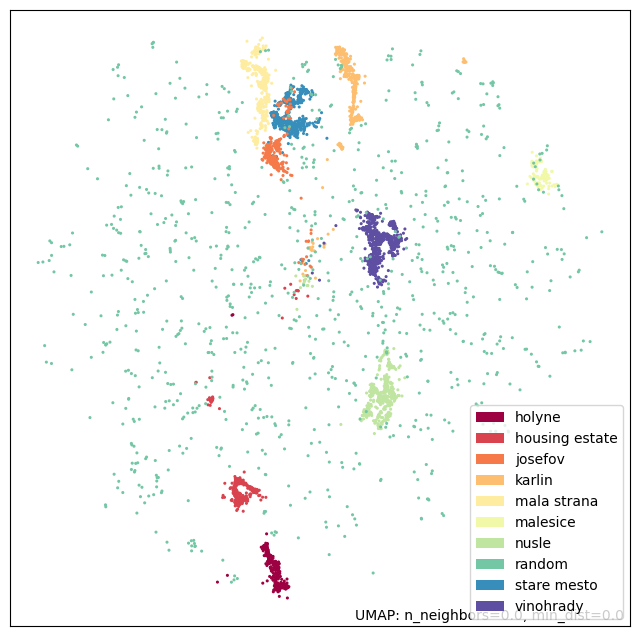

In [56]:
plot_datashade_umap(spatial_embedding[tess_groups_ilocs], tess_groups.values)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

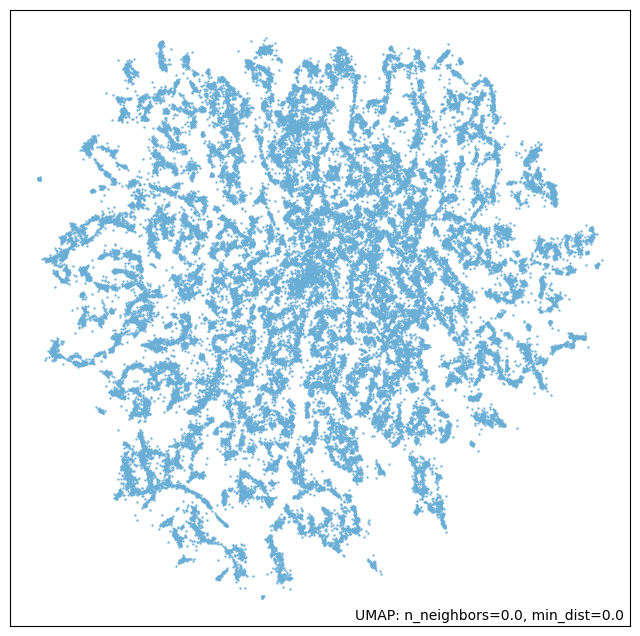

In [57]:
plot_datashade_umap(spatial_embedding)

<Axes: >

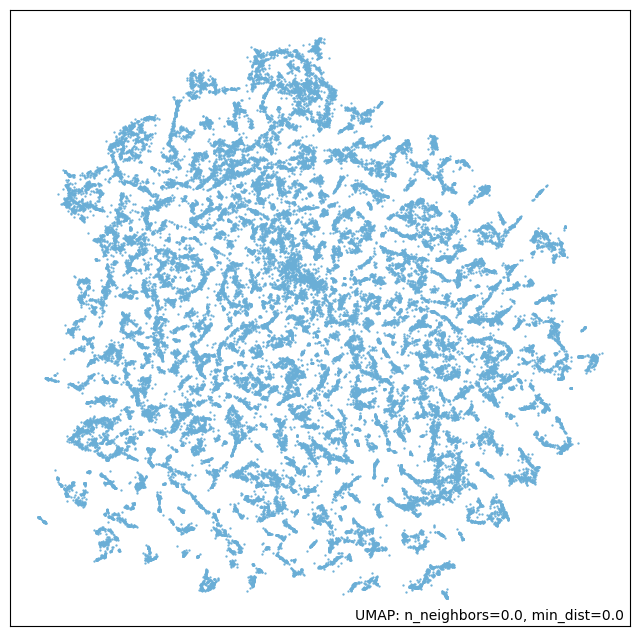

In [58]:
plot_datashade_umap(embedding)

In [59]:
davies_bouldin_score(
    spatial_embedding[tess_groups_ilocs], 
    tess_groups.values
)

np.float64(1.273048865518082)

In [60]:
davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

np.float64(2.420434964881649)

In [75]:
%%time

from evoc.clustering import build_cluster_layers
min_num_clusters = 4
min_samples = n_neighbors * 2
base_min_cluster_size = n_neighbors
next_cluster_size_quantile = .8

cluster_layers, membership_strengths = build_cluster_layers(
            embedding,
            min_clusters=min_num_clusters,
            min_samples=min_samples,
            base_min_cluster_size=base_min_cluster_size,
            next_cluster_size_quantile=next_cluster_size_quantile,
)

CPU times: user 5.82 s, sys: 36 ms, total: 5.86 s
Wall time: 723 ms


In [45]:
# %%time

# from core.generate_streets import record_batch_reader

# region_name = 69300
# regions_datadir = "/data/uscuni-ulce/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "regions_hull.parquet"
#     )
# region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.to_crs(epsg=4326).loc[region_name].convex_hull

# batches = record_batch_reader('division_area', bbox=region_hull.bounds).read_all()
# gdf = gpd.GeoDataFrame.from_arrow(batches)
# gdf = gdf.iloc[gdf.sindex.query(region_hull, predicate='intersects')]

# prague_neighbourhoods = gdf[gdf['subtype'] == 'locality'].set_crs(epsg=4326)
# prague_neighbourhoods['names'] = prague_neighbourhoods['names'].apply(lambda x: x['primary'])
# prague_neighbourhoods = prague_neighbourhoods[['geometry', 'names']].to_crs(epsg=3035)
# prague_neighbourhoods.to_parquet('../data/prague_neighbourhoods.parquet')

In [46]:
# import bokeh
# prague_neighbourhoods = gpd.read_parquet('../data/prague_neighbourhoods.parquet')

In [47]:
# umap.plot.output_notebook()


In [48]:
# plotting = tessellation.copy()
# plotting = plotting[plotting.index.isin(X_train.index)]
# inp, res = plotting.representative_point().sindex.query(prague_neighbourhoods.geometry, predicate='intersects')

In [49]:
# class MockEmbedding(object):
#     pass

# enb = MockEmbedding()
# enb.embedding = spatial_embedding[res]
# enb.n_neighbors = n_neighbors
# enb.min_dist = 0.0

In [50]:
# hover_data = X_train.iloc[res, :2]
# hover_data['label'] = prague_neighbourhoods.iloc[inp, 1].values

In [51]:
# p = umap.plot.interactive(enb, hover_data=hover_data, point_size=2)
# umap.plot.show(p)

In [53]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [54]:

min_cluster_size = n_neighbors

In [65]:
%%time
# sklearn_tree = KDTree(embedding)

sklearn_tree = KDTree(spatial_embedding)

numba_tree = kdtree_to_numba(sklearn_tree)
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)
sorted_mst = edges[np.argsort(edges.T[2])]
linkage_tree = mst_to_linkage_tree(sorted_mst)
condensed_tree = condense_tree(linkage_tree, min_cluster_size=100)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

CPU times: user 4.23 s, sys: 20.8 ms, total: 4.25 s
Wall time: 426 ms


In [76]:
clusters = cluster_layers[0]

In [77]:
np.unique(clusters, return_counts=True)

(array([  -1,    0,    1, ..., 1868, 1869, 1870]),
 array([110290,    160,    112, ...,    171,    240,     34]))

In [78]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [79]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters
plotting = plotting[plotting["label"] >= 0]

In [80]:
def get_color(labels_to_color):

    import glasbey
    
    def hex_to_rgb(hexa):
        return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))
    
    if plotting["label"].max() > 12:
        gb_cols = glasbey.extend_palette(
            Set3_12.hex_colors, palette_size=np.unique(labels_to_color).shape[0] + 1
        )
    else:
        gb_cols = Set3_12.hex_colors
    
    gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]
    
    colors = apply_categorical_cmap(
        plotting["label"], cmap=dict(zip(np.unique(labels_to_color), gb_cols, strict=False))
    )
    return colors

In [81]:
colors = get_color(clusters)

In [82]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [85]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m